# Question 6

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import animation
import matplotlib.colors as colors
from IPython.display import HTML

%matplotlib inline
cmap = cm.Blues
scl = 10

## Computation of Particle Path

The following functions are used to compute the position, velocity, and acceleration of the moving particle at a time $t$.

In [2]:
w = 1
v0 = 0.1
x0 = v0/w

def path(t):
    return x0*np.sin(w*t), 0, v0*t

def path_deriv(t):
    return x0*w*np.cos(w*t), 0, v0

def path_deriv_2(t):
    return -x0*w**2 * np.sin(w*t), 0, 0

## Newton's Method Functions

The following functions are used for Newton's method when solving for the retarded time.

In [3]:
def rooter(tr, t, x, y, z):
    r = np.array([x,y,z])
    w = np.array(path(tr))
    return tr-t+np.sqrt(np.dot(r-w, r-w))

def rooter_slope(tr, t, x, y, z):
    r = np.array([x,y,z])
    w = np.array(path(tr))
    w_v = np.array(path_deriv(tr))

    numerator = np.dot(r-w, w_v)
    denominator = np.sqrt(np.dot(r-w, r-w))
    
    return 1 - numerator/denominator
    
def newtons_method(tr, t, x, y, z, N):
    for i in range(N):
        tr = tr - rooter(tr, t, x, y, z)/rooter_slope(tr, t, x, y, z)
    return tr

## Computation of Electric and Magnetic Field

These methods are used to compute the electric field at a point $\vec{r}=(x,y,z)$ at a given time $t$ (note that the time $t$ specifies the location of the moving particle). Note that the retarded time depends both on $(x,y,z)$ and the time $t$ and needs to be taken into account here.

In [4]:
def elec_field(x, y, z, t):
    
    tr = newtons_method(t, t, x, y, z, 20)
    
    a = path_deriv_2(tr)
    
    script_r_vec = (np.array([x,y,z])-np.array(path(tr)))
    script_r = np.linalg.norm(script_r_vec)
    script_r_hat = (1/script_r)*script_r_vec
    
    Beta = np.array(path_deriv(tr))
    alpha = script_r_hat-Beta
    Beta_square = np.linalg.norm(Beta)**2
    
    return script_r/(np.dot(script_r_vec, alpha))**3 * ((1-Beta_square)*alpha+
                                                       np.cross(script_r_vec, np.cross(alpha, a)))

def mag_field(x, y, z, t):
    tr = newtons_method(t, t, x, y, z, 20)
    script_r_vec = (np.array([x,y,z])-np.array(path(tr)))
    script_r = np.linalg.norm(script_r_vec)
    script_r_hat = (1/script_r)*script_r_vec
    
    [E_x, E_y, E_z] = elec_field(x, y, z, t)
    
    return np.cross(script_r_hat, np.array([E_x, E_y, E_z]))

Used to compute at each grid point.

In [5]:
def get_elec_field(X_d, Z_d, t):
    Rx = np.zeros(shape=X_d.shape)
    Ry = np.zeros(shape=X_d.shape)
    Rz = np.zeros(shape=X_d.shape)
    for i in range(len(X_d)):
        for j in range(len(X_d[i])):
            [field_x, field_y, field_z] = elec_field(X_d[i,j], 0, Z_d[i,j], t)
            Rx[i, j] = field_x
            Ry[i, j] = field_y
            Rz[i, j] = field_z
    return Rx, Ry, Rz

def get_mag_field(X_d, Z_d, t):
    Rx = np.zeros(shape=X_d.shape)
    Ry = np.zeros(shape=X_d.shape)
    Rz = np.zeros(shape=X_d.shape)
    for i in range(len(X_d)):
        for j in range(len(X_d[i])):
            [field_x, field_y, field_z] = mag_field(X_d[i,j], 0, Z_d[i,j], t)
            Rx[i, j] = field_x
            Ry[i, j] = field_y
            Rz[i, j] = field_z
    return Rx, Ry, Rz

## Store Data for Plotting

Specifies the array of times used.

In [6]:
x=1
y=1
z=1
t = 5
ttr = np.linspace(0, 3*np.pi/w, 30)

Creates a pandas DataFrame which is used to store all the components of the fields at any given time. This is used because it makes handling animation easier, and provides an efficient way for storing data.

In [7]:
df = pd.DataFrame({'Time': ttr})
df['Position_Current'] = df['Time'].apply(lambda t: path(t))

X_d, Z_d = np.meshgrid(np.arange(-0.5, 0.5, .1), np.arange(0, 1 , .1))
df['E_Field'] = df['Time'].apply(lambda t: get_elec_field(X_d, Z_d, t))
df['B_Field'] = df['Time'].apply(lambda t: get_mag_field(X_d, Z_d, t))

df['E_Field_x'] = df['E_Field'].apply(lambda x: x[0])
df['E_Field_y'] = df['E_Field'].apply(lambda x: x[1])
df['E_Field_z'] = df['E_Field'].apply(lambda x: x[2])

df['B_Field_x'] = df['B_Field'].apply(lambda x: x[0])
df['B_Field_y'] = df['B_Field'].apply(lambda x: x[1])
df['B_Field_z'] = df['B_Field'].apply(lambda x: x[2])


mag_E = (df['E_Field_x']**2+df['E_Field_y']**2+df['E_Field_z']**2)**(1/2)
df['E_Field_x'] = df['E_Field_x']/mag_E
df['E_Field_y'] = df['E_Field_y']/mag_E
df['E_Field_z'] = df['E_Field_z']/mag_E

mag_B = (df['B_Field_x']**2+df['B_Field_y']**2+df['B_Field_z']**2)**(1/2)
df['B_Field_x'] = df['B_Field_x']/mag_B
df['B_Field_y'] = df['B_Field_y']/mag_B
df['B_Field_z'] = df['B_Field_z']/mag_B

Compute another column in the DataFrame which corresponds to the electric field magnitudes.

In [8]:
X_m, Z_m = np.meshgrid(np.arange(-0.5, 0.5, .01), np.arange(0, 1 , .01))
df['E_Field_mag'] = df['Time'].apply(lambda t: get_elec_field(X_m, Z_m, t))
df['E_Field_mag'] =  df['E_Field_mag'].apply(lambda x: (x[0]**2+x[1]**2+x[2]**2)**(1/2))
df['B_Field_mag'] = df['Time'].apply(lambda t: get_mag_field(X_m, Z_m, t))
df['B_Field_mag'] =  df['B_Field_mag'].apply(lambda x: (x[0]**2+x[1]**2+x[2]**2)**(1/2))

Get the path of the particle to be plotted on the electric and magnetic field plots.

In [9]:
wx, wy, wz = path(ttr)

## Miscellanious Functions Used for Plotting and Animation

Used to plot the magnetic field x's and o's for the y-field direction.

In [40]:
def mag_dir_plot(mag_field_y, ax):
    for i in range(len(mag_field_y)):
        for j in range(len(mag_field_y[i])):
            if mag_field_y[i,j]>0:
                ax.scatter(X_d[i,j], Z_d[i,j], marker='x', color='k')
            if mag_field_y[i,j]<0:
                ax.scatter(X_d[i,j], Z_d[i,j], color='k')

Used for creating a video animation

In [41]:
def animate(i):
    
    [a.clear() for a in ax]
    
    ax[0].pcolor(X_m, Z_m, df['E_Field_mag'][i], cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    ax[1].pcolor(X_m, Z_m, df['B_Field_mag'][i], cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=1000))
        
        
    ax[0].quiver(X_d, Z_d, df['E_Field_x'][i], df['E_Field_z'][i], units='width')

    mag_dir_plot(df['B_Field_y'][i], ax[1])

    [a.scatter(path(ttr[i])[0], path(ttr[i])[2], color='r') for a in ax]
    [a.plot(wx, wz, color='k') for a in ax]
    
    [a.set_ylim(0, 0.9) for a in ax]
    [a.set_xlim(-0.5, 0.5) for a in ax]

    [a.set_xlabel(r'Position in x [$\cdot 10 x_0$]') for a in ax]
    [a.set_ylabel(r'Position in z [$\cdot 10 x_0$]') for a in ax]
    
    ax[0].set_title('Electric Field')
    ax[1].set_title('Magnetic Field')

Used to create individual plots.

In [42]:
def plotter(i):
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))


    cs1 = ax[0].pcolor(X_m, Z_m, df['E_Field_mag'][i], cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    cbar1 = fig.colorbar(cs1, ax=ax[0], extend='both', label=r'$\left(\frac{4 \pi \epsilon_0}{q}\right)|\vec{E}|$')

    cs2 = ax[1].pcolor(X_m, Z_m, df['B_Field_mag'][i], cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    cbar2 = fig.colorbar(cs1, ax=ax[1], extend='both', label=r'$\left(\frac{4 \pi \epsilon_0}{qc}\right)|\vec{B}|$')
    
    ax[0].quiver(X_d, Z_d, df['E_Field_x'][i], df['E_Field_z'][i], units='width')

    mag_dir_plot(df['B_Field_y'][i], ax[1])

    [a.scatter(path(ttr[i])[0], path(ttr[i])[2], color='r') for a in ax]
    [a.plot(wx, wz, color='k') for a in ax]
    
    [a.set_ylim(0, 0.9) for a in ax]
    [a.set_xlim(-0.5, 0.5) for a in ax]

    [a.set_xlabel(r'Position in x [$\cdot 10 x_0$]') for a in ax]
    [a.set_ylabel(r'Position in z[$\cdot 10 x_0$]') for a in ax]
    
    ax[0].set_title('Electric Field')
    ax[1].set_title('Magnetic Field')

## Animation

Setup the animation.

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

cs1 = ax[0].pcolor(X_m, Z_m, df['E_Field_mag'][0], cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=1000))
cbar1 = fig.colorbar(cs1, ax=ax[0], extend='both', label=r'$\left(\frac{4 \pi \epsilon_0}{q}\right)|\vec{E}|$')

cs2 = ax[1].pcolor(X_m, Z_m, df['B_Field_mag'][0], cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=1000))
cbar2 = fig.colorbar(cs1, ax=ax[1], extend='both', label=r'$\left(\frac{4 \pi \epsilon_0}{qc}\right)|\vec{B}|$')

ani = animation.FuncAnimation(fig, animate, len(ttr), interval=1e2, blit=False)

HTML(ani.to_html5_video())

plt.close()

Save to an mp4 file.

In [44]:
ani.save('eb_field.mp4', fps=9, dpi=300)

## 10 Plots at Various Times

(Note that $c=1$ here so position and time are measured in the same units)

**Note 1**

In the magnetic field plots, an x represents the magnetic field pointing into the page in the $+y$ direction and a dot represents the magnetic field pointing out of the page in the $-y$ direction.

**Note 2**

While the times are not explicitly shown on the plots, note that it takes $T=2\pi/\omega$ time to complete one wavelength of the path shown below where $\omega = v_0/x_0 = 0.1/x_0$ where $x_0$ is the amplitude of the wave.


In summary: $$T=20 \pi x_0$$

where $T$ is the period of 1 sinusoidal cycle of the particle and $x_0$ is the amplitude of the sinusoidal path. One can choose any appropriate unit system with these characteristics and the plots below hold true (I mean, provided things arent *too* small and QED takes over). One can convert this into classical units of meters and seconds by appropriately multiplying by $c$.

The velocity $v_0=0.1c$ is set in stone, however, so the scaling on the fields *do not* change. This is convenient for the colormap legends we use- they are valid for any position and time units we use as long as $T=20 \pi x_0$ is satisfied.

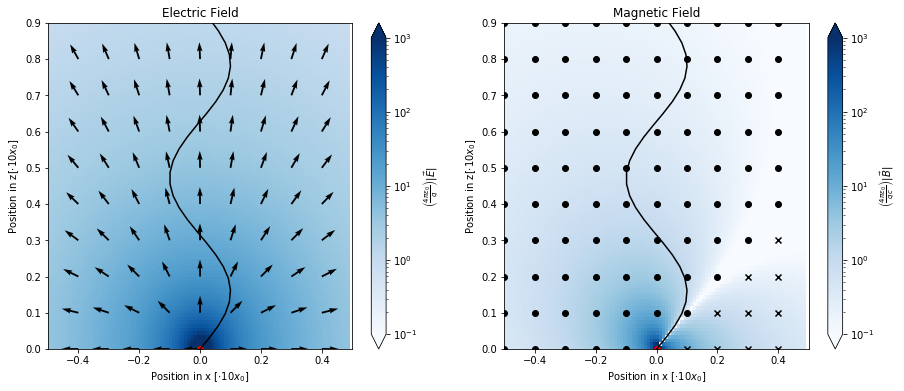

In [45]:
plotter(0)

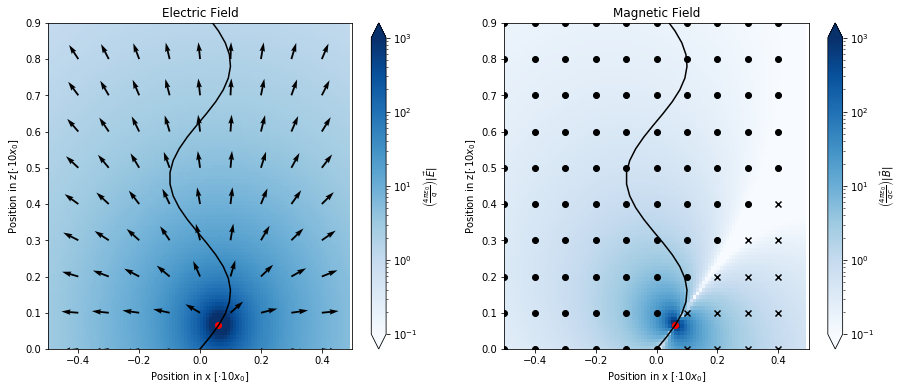

In [46]:
plotter(2)

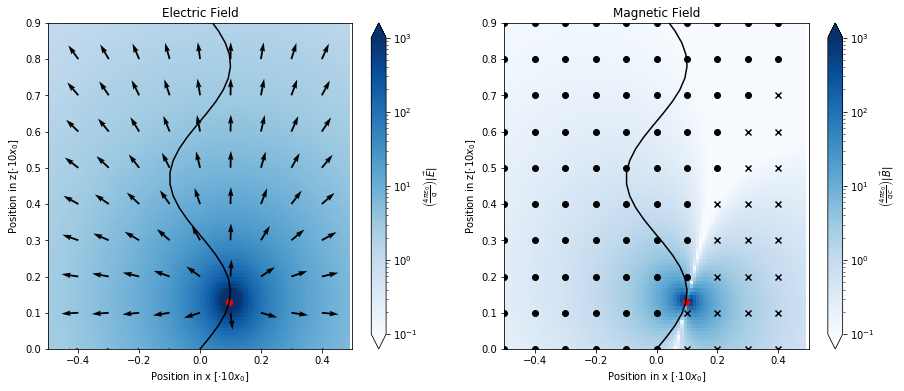

In [47]:
plotter(4)

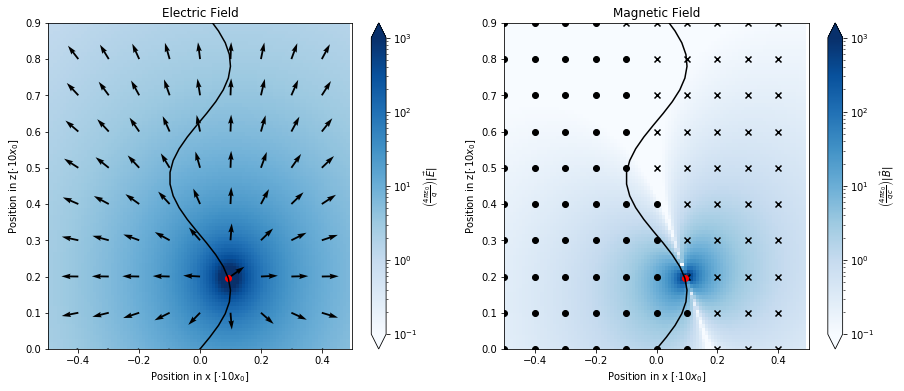

In [48]:
plotter(6)

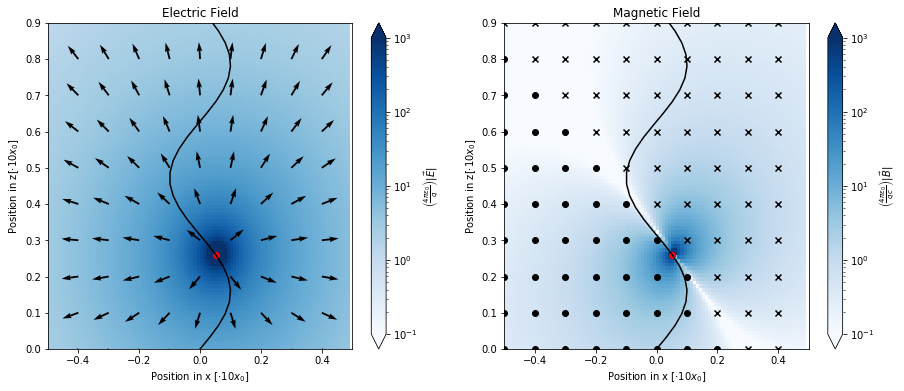

In [49]:
plotter(8)

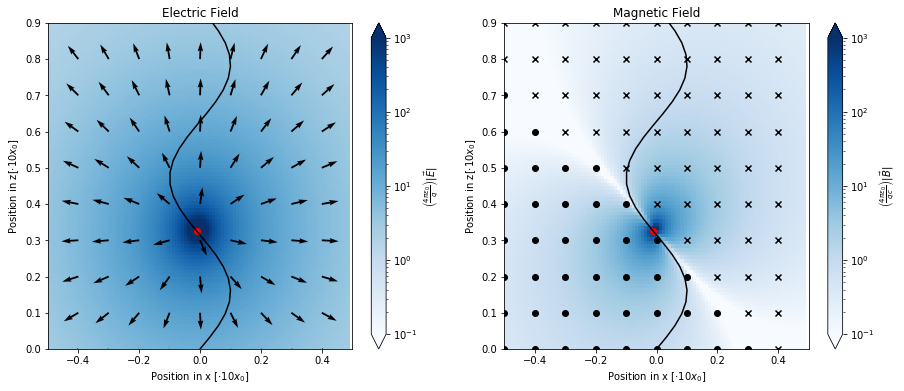

In [50]:
plotter(10)

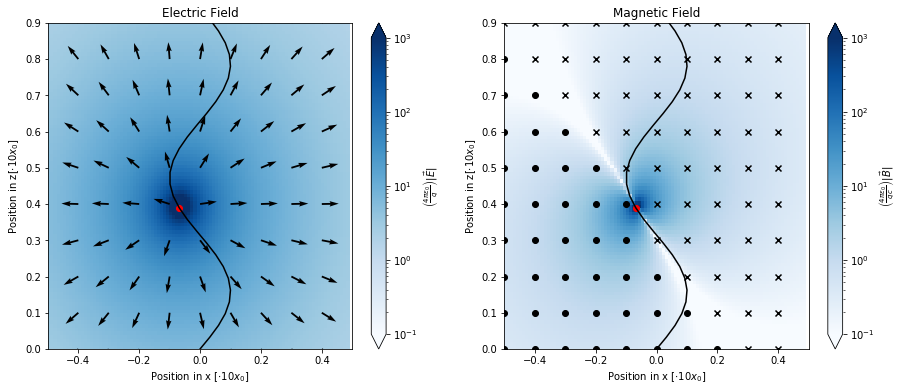

In [51]:
plotter(12)

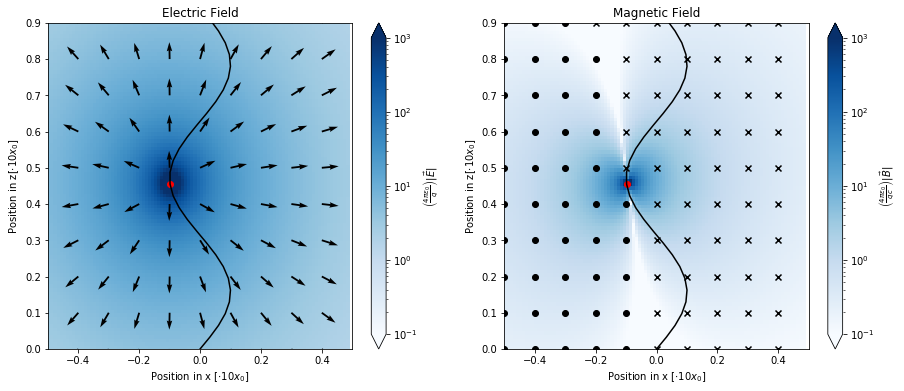

In [52]:
plotter(14)

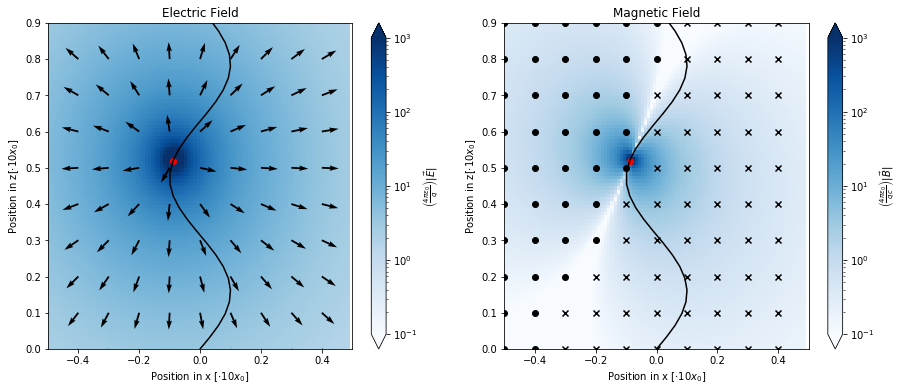

In [53]:
plotter(16)

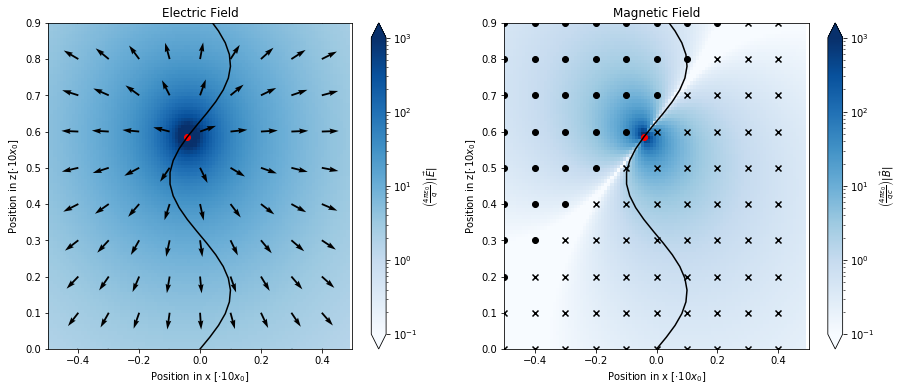

In [54]:
plotter(18)

**See the email I sent you for the actual animation.**